In [1]:
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt
from pathlib import Path

# ===== 基本设置 =====
FS = 5  # 采样率（Hz），如果你的数据不是 5Hz，记得改这里
EDA_COL = "eda_uS"       # 你的 EDA 列名
TIME_COL = "timestamp"   # 时间戳列名


def process_single_file(csv_path,
                        sampling_rate=FS,
                        eda_col=EDA_COL,
                        time_col=TIME_COL):
    csv_path = Path(csv_path)
    print(f"Processing: {csv_path}")

    # 1. 读入数据 -------------------------------------------------
    df = pd.read_csv(csv_path)

    # 如果时间戳是字符串，解析为 datetime
    if time_col in df.columns:
        df[time_col] = pd.to_datetime(df[time_col])

    # 2. 取出 EDA 信号，并做插值补 NaN --------------------------
    if eda_col not in df.columns:
        raise ValueError(f"Column '{eda_col}' not found in file {csv_path}")

    eda_raw = df[eda_col].astype(float)
    # 用线性插值补齐 NaN，避免 NeuroKit 出错
    eda_interp = eda_raw.interpolate(limit_direction="both")

    # 3. NeuroKit2 预处理 + SCL/SCR 分解 ------------------------
    # signals 里会包含：
    # 'EDA_Raw', 'EDA_Clean', 'EDA_Tonic', 'EDA_Phasic',
    # 'SCR_Amplitude', 'SCR_RiseTime', 'SCR_RecoveryTime',
    # 'SCR_Onsets', 'SCR_Peaks', ...
    signals, info = nk.eda_process(eda_interp, sampling_rate=sampling_rate)

    # 4. 合并回原始 df -------------------------------------------
    processed = pd.concat(
        [df.reset_index(drop=True), signals.reset_index(drop=True)],
        axis=1
    )

    # 5. 计算一些简单的全局特征（方便之后对比不同 user）---------
    scr_peaks_mask = processed["SCR_Peaks"] == 1

    features = {
        "file": csv_path.name,
        "n_samples": len(processed),
        "mean_scl": processed["EDA_Tonic"].mean(),
        "std_scl": processed["EDA_Tonic"].std(),
        "mean_phasic": processed["EDA_Phasic"].mean(),
        "scr_count": scr_peaks_mask.sum(),
        "scr_mean_amplitude": processed.loc[scr_peaks_mask,
                                            "SCR_Amplitude"].mean(),
    }

    # 6. 简单画一张全程的 clean / SCL / SCR（可选）---------------
    if time_col in processed.columns:
        x = processed[time_col]
    else:
        # 没有时间戳就用样本序号代替
        x = range(len(processed))

    plt.figure(figsize=(14, 5))
    plt.plot(x, processed["EDA_Clean"], label="EDA Clean", alpha=0.6)
    plt.plot(x, processed["EDA_Tonic"], label="EDA Tonic (SCL)", linewidth=2)
    plt.plot(x, processed["EDA_Phasic"], label="EDA Phasic (SCR)", linewidth=1)
    plt.legend()
    plt.title(f"EDA Decomposition - {csv_path.name}")
    plt.xlabel("Time")
    plt.ylabel("μS")
    plt.tight_layout()
    plt.show()

    return processed, features

Processing: /Users/jianingyu/Downloads/MAS-S63_project/visualizations/JINGFEI1117/v6_raw.csv


/Users/jianingyu/Downloads/MAS-S63_project/.venv/lib/python3.11/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(


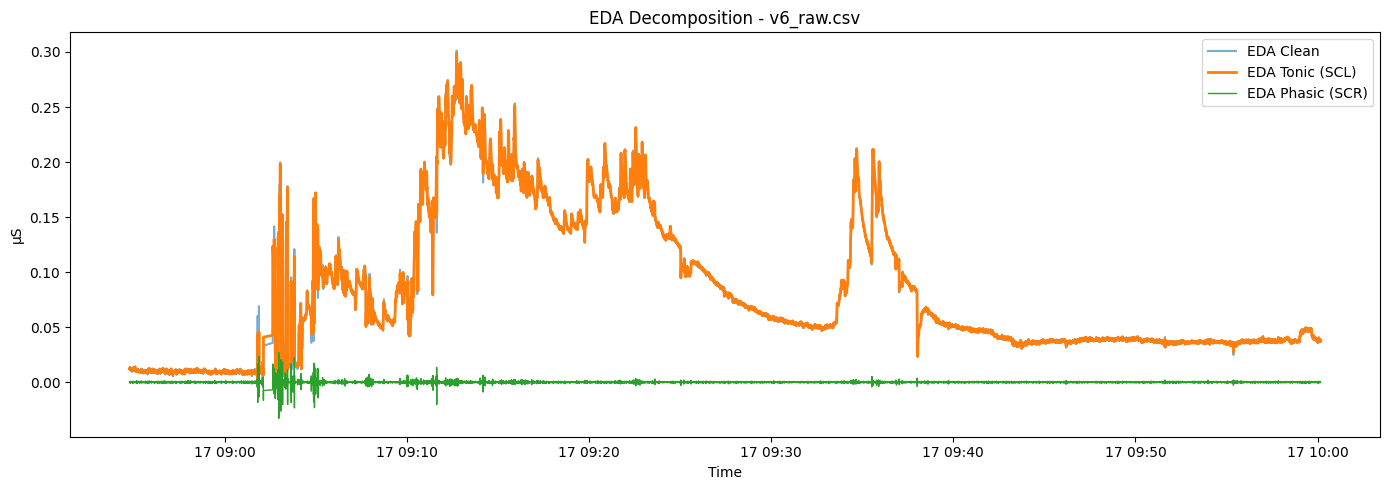

{'file': 'v6_raw.csv', 'n_samples': 522535, 'mean_scl': np.float64(0.08242457973041041), 'std_scl': np.float64(0.06416663527284522), 'mean_phasic': np.float64(-1.371038133979957e-09), 'scr_count': np.int64(145), 'scr_mean_amplitude': np.float64(0.010202710229935005)}


,timestamp,acc_x_g,acc_y_g,acc_z_g,eda_uS,temperature_c,bvp,EDA_Raw,EDA_Clean,EDA_Tonic,EDA_Phasic,SCR_Onsets,SCR_Peaks,SCR_Height,SCR_Amplitude,SCR_RiseTime,SCR_Recovery,SCR_RecoveryTime
0,2025-11-17 08:54:46.844450-05:00,NaN,NaN,NaN,NaN,NaN,NaN,0.011995,0.011995,0.011968,0.000026,0,0,0.0,0.0,0.0,0,0.0
1,2025-11-17 08:54:46.847624-05:00,NaN,NaN,NaN,NaN,NaN,0.00000,0.011995,0.011995,0.011968,0.000026,0,0,0.0,0.0,0.0,0,0.0
2,2025-11-17 08:54:46.860075-05:00,0.005368,-0.013664,1.011624,NaN,NaN,NaN,0.011995,0.011995,0.011969,0.000026,0,0,0.0,0.0,0.0,0,0.0
3,2025-11-17 08:54:46.863249-05:00,NaN,NaN,NaN,NaN,NaN,0.00001,0.011995,0.011995,0.011969,0.000026,0,0,0.0,0.0,0.0,0,0.0
4,2025-11-17 08:54:46.875700-05:00,0.009760,-0.020496,1.010160,NaN,NaN,NaN,0.011995,0.011995,0.011970,0.000025,0,0,0.0,0.0,0.0,0,0.0


In [ ]:
# 跑一位用户的 raw.csv
processed_df, global_feats = process_single_file(
    "/Users/jianingyu/Downloads/MAS-S63_project/visualizations/JINGFEI1117/v6_raw.csv"
)
print(global_feats)

# 之后所有可视化都用 processed_df
# processed_df.head()


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
import pytz

eastern = pytz.timezone("US/Eastern")


def plot_eda_interval_aligned(df,
                              start_time=None,
                              end_time=None,
                              time_col="timestamp",
                              eda_clean_col="EDA_Clean",
                              scl_col="EDA_Tonic",
                              scr_col="EDA_Phasic"):
    """
    让 EDA 的 plot：
    - 使用 US/Eastern 时区
    - x 轴主刻度 1 分钟，次刻度 10 秒
    - 宽度随时间长度动态变化（和你原来的公式一致）
    """

    df = df.copy()

    # 1. 确保时间列是 datetime，并且是 tz-aware（US/Eastern）
    if not pd.api.types.is_datetime64_any_dtype(df[time_col]):
        df[time_col] = pd.to_datetime(df[time_col])

    if pd.api.types.is_datetime64tz_dtype(df[time_col].dtype):
        # 已经有时区：统一转为 Eastern
        df[time_col] = df[time_col].dt.tz_convert(eastern)
    else:
        # 没有时区：localize 为 Eastern
        df[time_col] = df[time_col].dt.tz_localize(eastern)

    # 2. 处理 start_time / end_time（统一为 Eastern tz-aware）
    if start_time is not None:
        st = pd.to_datetime(start_time)
        if st.tzinfo is None:
            st = eastern.localize(st)
        else:
            st = st.astimezone(eastern)
        df = df[df[time_col] >= st]
    else:
        st = df[time_col].iloc[0]

    if end_time is not None:
        et = pd.to_datetime(end_time)
        if et.tzinfo is None:
            et = eastern.localize(et)
        else:
            et = et.astimezone(eastern)
        df = df[df[time_col] <= et]
    else:
        et = df[time_col].iloc[-1]

    if df.empty:
        print("选定区间内没有数据！")
        return

    # 把最终使用的 start/end（经过截取后的真实边界）拿出来
    start_time_final = df[time_col].iloc[0]
    end_time_final = df[time_col].iloc[-1]

    x = df[time_col]

    # 3. 动态宽度（按时长）——与你原来的一致
    duration_seconds = max(
        (end_time_final - start_time_final) / timedelta(seconds=1),
        1
    )
    # 下面这个就是你之前写的：duration_seconds * (1/60) * 1
    width = duration_seconds * (1 / 6) * 1

    fig, ax = plt.subplots(figsize=(width, 4))

    # 4. 画三条曲线：Clean / SCL / SCR
    ax.plot(x, df[eda_clean_col], label="EDA Clean", alpha=0.6)
    ax.plot(x, df[scl_col], label="EDA Tonic (SCL)", linewidth=2)
    ax.plot(x, df[scr_col], label="EDA Phasic (SCR)", linewidth=1)

    # 5. 设置 x 轴刻度：1 分钟 major，10 秒 minor，Eastern 时区
    major_locator = mdates.MinuteLocator(interval=1, tz=eastern)
    major_formatter = mdates.DateFormatter("%H:%M", tz=eastern)
    minor_locator = mdates.SecondLocator(bysecond=range(0, 60, 10), tz=eastern)

    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_major_formatter(major_formatter)
    ax.xaxis.set_minor_locator(minor_locator)

    plt.xticks(rotation=45)
    plt .show()

/var/folders/22/0vpdqgyx5q717n66h48gjd500000gn/T/ipykernel_18089/1364720870.py:30: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(df[time_col].dtype):


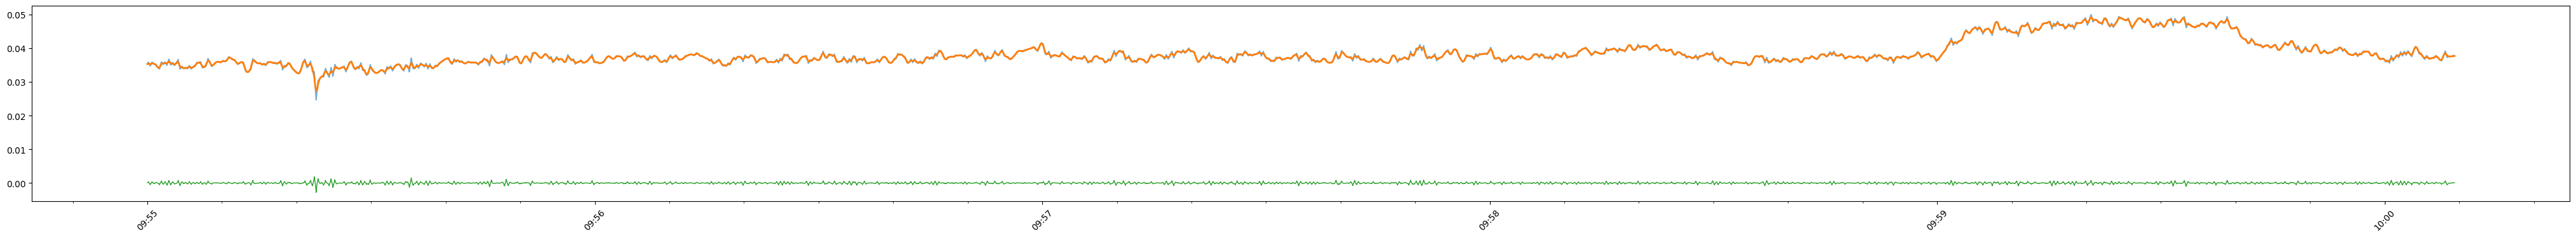

In [20]:
plot_eda_interval_aligned(
    processed_df,
    start_time="2025-11-17 09:55:00",
    end_time="2025-11-17 10:05:00"
)